In [2]:
%matplotlib inline
import matplotlib
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 2 * matplotlib.rcParams['savefig.dpi']

# Visualization using D3.js

In this section, we'll show you how to do things in d3 that you're doing in pandas.  First, run the following command from the command line.  This downloads data from the Social Security Administration giving baby names going back to 1884:

``` bash
python projects/babyname/src/save_babynames_data.py
```

Once this has run (it takes 30 seconds or so), run

``` bash
ls -l projects/babyname/data/*.csv
```

to make sure the files have been created.  First, we're going to do this in pandas.

In [3]:
import pandas as pd
# read in
birthnames = pd.read_csv("projects/babyname/data/birthnames.csv")
birthnames.head()

,Unnamed: 0,name,sex,births,year,rank,frac
0,0,Mary,F,7065,1880,1,0.077643
1,1,Anna,F,2604,1880,2,0.028618
2,2,Emma,F,2003,1880,3,0.022013
3,3,Elizabeth,F,1939,1880,4,0.021309
4,4,Minnie,F,1746,1880,5,0.019188


We're now going to plot a few pairs of data.

/Users/ashkan/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:10: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


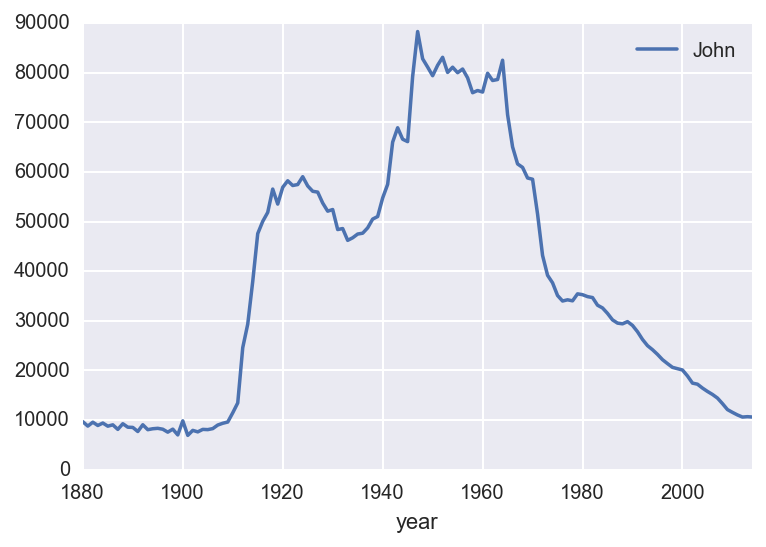

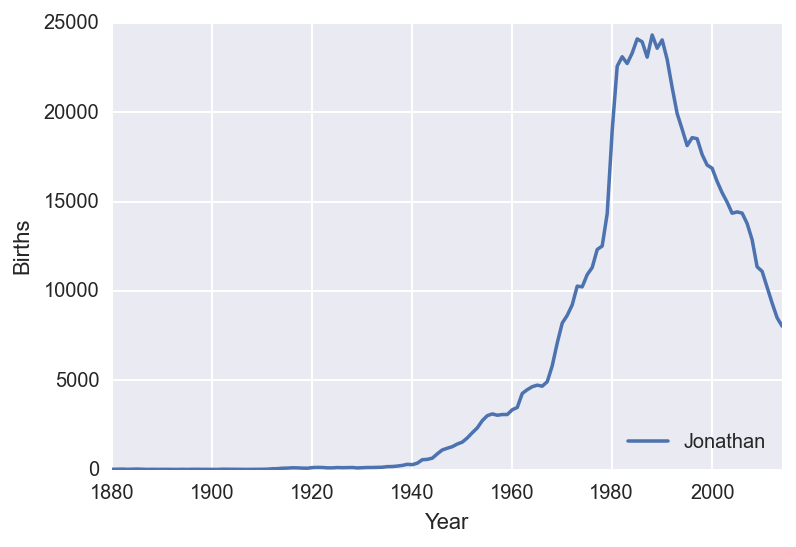

In [4]:
from matplotlib import pylab as plt
import seaborn as sns

boys = birthnames[birthnames.sex == 'M']
girls = birthnames[birthnames.sex == 'F']

def plot_name_frac(sex, name):
    series = boys[boys.name == name] if sex == 'M' else girls[girls.name == name]
    try:
        series.sort(columns='year').plot(x='year', y='births', label=name)
    except TypeError:
        pass

plt.figure()
plot_name_frac('M', 'John')
plot_name_frac('M', 'Jonathan')
plt.xlabel("Year")
plt.ylabel("Births")
plt.legend(loc='lower right')


## Static D3

We can do the same thing in d3.  There are three main parts to this code.  Check out [John versus Jonathan in d3](projects/babyname/name_pairs.html).

1.  The first part is the HTML tag which indicates where the chart will go.

    ``` html
    <div id="chart"><svg></svg></div>
    ```

2.  The second two parts are the JavaScript.  First we need to load the data.  

    ``` javascript
    d3.csv("data/birthnames_top_100.csv", function(error, data) {
        // do something with data
    })
    ```

    This is an asynchronous call to JavaScript.  That means the call returns immediately to execute the next line in the script.  When the file `data/birthnames_top_100.csv` is downloaded, the callback function (the anonymous function `function(error, data) { ... }` is then called with `data` representing the data that was loaded.  Hence, we must execute all our code in this callback.

    A brief note: `data/birthnames_top_100.csv` is actually returned via HTTP (point your browser to [birthnames_top_100.csv](projects/babyname/data/birthnames_top_100.csv) if you don't believe me).  This means that this file could be any csv file on the internet and it could be an API response generated dynamically by a server.  In our case, it happens to be a static file you generated at the beginning of this tutorial.  The server that powers this notebook is translating the HTTP request to fetching the corresponding file from disk.

3.  The code that generates the graph is here:

    ```javascript
    function bindAndRender(myData, maxBirths) {
        nv.addGraph(function() {
            chart = nv.models.lineChart()
                        .x(function(d) { return d.year })
                        .y(function(d) { return d.births })
                        .margin({left: 100})
                        .useInteractiveGuideline(true)
                        .transitionDuration(350)
                        .showLegend(true)
                        .showYAxis(true)
                        .showXAxis(true)
                        .forceY([0, maxBirths]);

          chart.xAxis.axisLabel('Year');

          chart.yAxis.axisLabel("Births");

          d3.select('#chart svg')    //Select the <svg> element for the chart.
              .datum(myData)         //Populate the <svg> element with chart myData...
              .call(chart);          //Finally, render the chart!
      });
    };
    ```
    
    This is actually using a library called `nvd3` which encapsulates a lot of the very basic functionality that `d3` offers.  Basically, `chart` specifies a bunch of rules for how to draw the data and `d3.select` binds (associates) the data with the html element set by the jQuery selector `'#chart svg'`.  This code demonstrates a few nifty aspects of JavaScript:
    - **Chaining:** `nv.models.lineChart()` returns a `chart` object.  Calling the method `.x` modifies it and returns the new modified instance of the object.  Calling the method `.y` ...
    - **Callbacks:** notice that both `.x` and `.y` require a function.  This function, when given an instance that will be bound to it (`d`), returns the attribute to set on the x and y axes.  The object `chart` is actually a function, which is called via the `.call` method by the selection `d3.select` with the data bound by the call to `.datum`.  Finally, the function `addGraph` takes a callback itself.
    - **jQuery selectors:** Recall that "#chart svg" selects an html element with `id="chart"` and an `svg` tag inside.
    - **Global versus local context:** notice that while the typical variable assignment pattern is
    
        ```javascript
        var chart = ...
        ```
     in here, we omit the `var`.  The `var` places the variable in the local context but here we want it in the global context, where we can use it again outside of this function (see below).
    
4.   Dynamic resizing.  The function `bindAndRender` is called when the page loads to bind (associate) the data with the chart.  Once this is done, all we have to do is reinvoke `.call(chart)` to redraw the chart.  This is done via a call-back associated with window resizing.  That is, the following line ensures that every time the window is resized, we issue another draw command:

    ```javascript
		window.addEventListener('resize', function(event){
			d3.select('#chart svg')
                .call(chart);
		});
    ```

    Notice that we can call `chart` here, which was left in the global context by the function `bindAndRender`.

**Exercise:** On the webpage in the above link, use `Cmd+Option+i` and click the console tab to enter the interactive JavaScript console in your browser.  Paste in these lines:
```javascript
d3.csv("data/birthnames_top_100.csv", function(error, data) {
    rawData = data;
})
```
Type `rawData` into the console.  Again, because we didn't use `var`, the variable `rawData` is placed in the global context.  Follow the data manipulation steps in the source code line by line (you can view the source code on your local machine).  The code uses a small but powerful library called [underscore.js](http://underscorejs.org/) which is imported as the symbol "`_`" (which is a valid variable name in JavaScript).

**Question:** In the above line of code, we save our data into `rawData`, a variable in our outer scope.  Why does this work in the console but would likely not have the intended side effect in a script?  Hint: this has to do with asynchronicity.

## Interactive D3

The last graph was static.  We're going to now show off the interactive power of d3 by combining it with angular, which is another JavaScript library.  Check out [Baby Name Popularity](projects/babyname/name_popularity.html).  

On the HTML side, we have introduced funny new attributes (called directives) with names that start with `ng`, e.g. `ng-repeat`, `ng-model`, `ng-click`.  These bind the specific HTML elements with JavaScript code.  On the JavaScript side, almost everything happens inside the controller `function NamesCtrl($scope)`.  You can think of the object `$scope` as representing all the variables and methods associated with this controller.

Below are a few features that you can play with which automatically update the graph:

<table style="width:100%">
<col width="60%">
<col width="40%">
<tr><th>
    These elements in HTML augmented with angular directives
</th>
<th>
    Call these functions in JavaScript
</th></tr>

<tr><td>
```
<div id="nameCtrl" ng-controller="NamesCtrl">
    ...
</div>
```
</td><td>
Associates all the code in this element (and sub-elements) with `function NamesCtrl($scope)`
</td></tr>

<tr><td>
```
<form ng-submit="addName()">
  <input type="text" ng-model="newName"
         placeholder="name to add">
  <input class="btn-primary" type="submit"
         value="add">
</form>```
</td><td>
This form calls `$scope.addName()` which adds values to `$scope.names`
</td></tr>

<tr><td>
`<input class="btn-primary" type="submit"
       ng-click="clearNames()" value="clear">`
</td><td>
Clears the names by calling `$scope.clearNames()`
</td></tr>

<tr><td>
`<ul class="unstyled">
  <li ng-repeat="name in names">
      ...
  </li>
</ul>`
</td><td>
The `ng-repeat="name in names"` directive creates a repeated list of `<li></li>` html elements which are each bound to `name`
</td></tr>

<tr><td>
`<input type="checkbox"
       ng-change="render()"
       ng-model="name.show">`
</td><td>
When the checkbox is clicked, the render function is called: `$scope.render()`.
This binds the checkbox to the model `name.show`
</td></tr>

<tr><td>
`<span>{{ name.name }}</span>`
</td><td>
The name in the span is bound to `name.name`
</td></tr>

</table>

The above code is all `angular code` that binds the user interface specifying which names to display with the JavaScript object `$scope.name`.

Our render function `$scope.render` is quite similar to that of the previous example except that it is inside the Controller (to get access to `$scope.names`) and has to filter for the names that we actually want to display data for, which is saved in `filteredData`:

```javascript
var filteredData = _.filter(scope.myData, function(d) {
    var activeNames = _.chain($scope.names)
            .filter(function(n) { return n.show; })
            .map(function(n) { return n.name; })
            .value();
    return _.contains(activeNames, d.label);
})
```


For more information, read a bit about [angular](https://angularjs.org), or more specifically look at this example of a [Todo List](https://angularjs.org/#add-some-control), which is what this example is patterned off of.

**Exercise:** Look at the plot of presidential first names below.  You can tell there's a spike in baby names around the time they are elected.  Reproduce this visualization in `d3`.  Highlight the portion of the data when they were president.

**Action Item:** Read through this introductory example by [Brock](http://bost.ocks.org/mike/bar/) and the online version of the [O'Reilly Book](http://alignedleft.com/tutorials/d3/)

/Users/ashkan/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:10: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


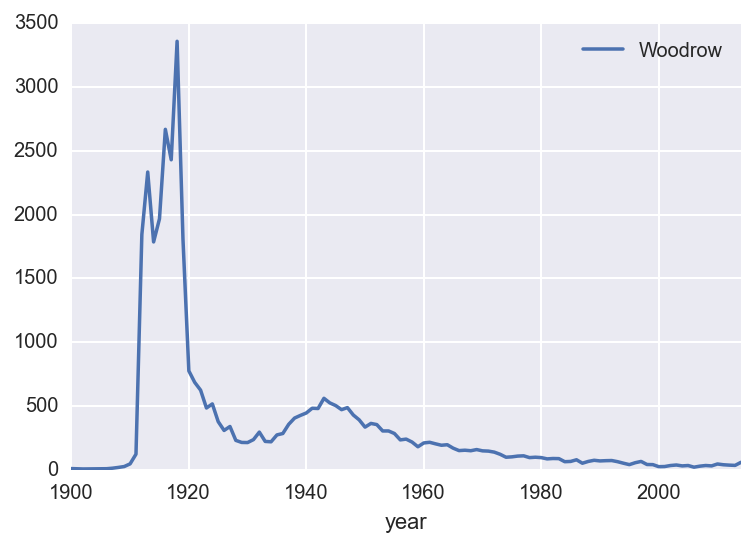

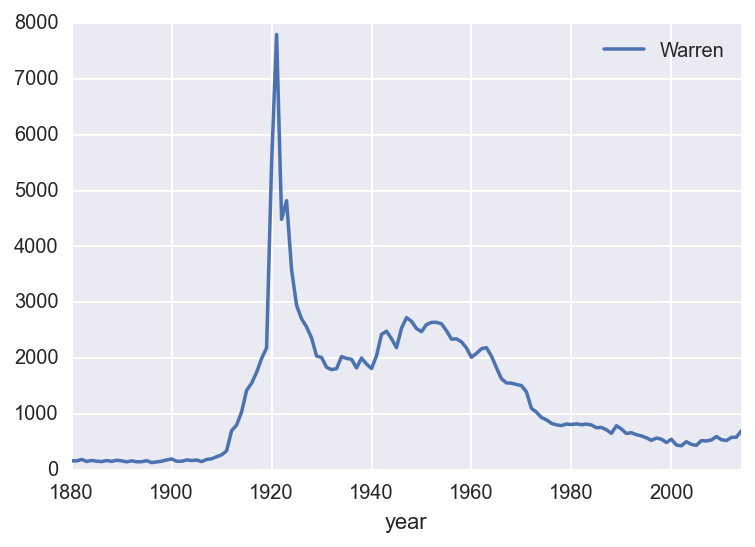

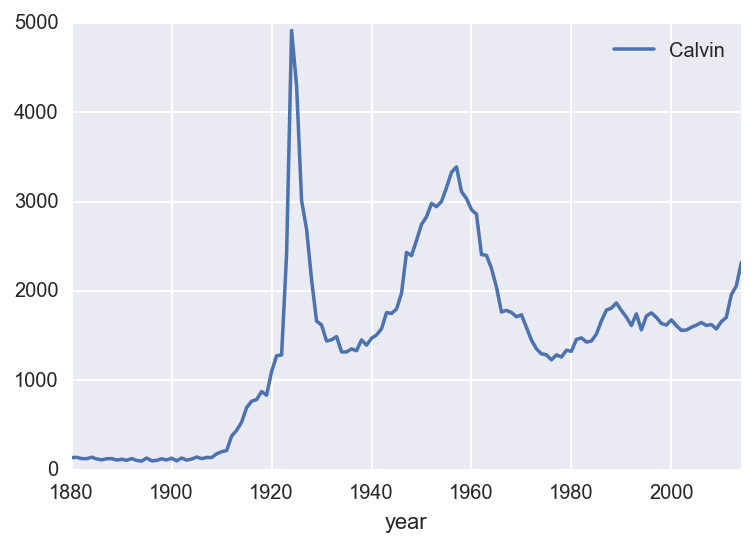

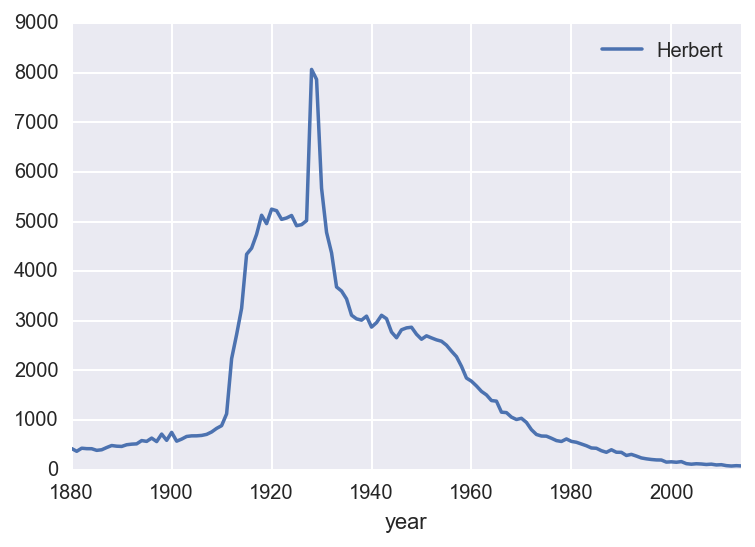

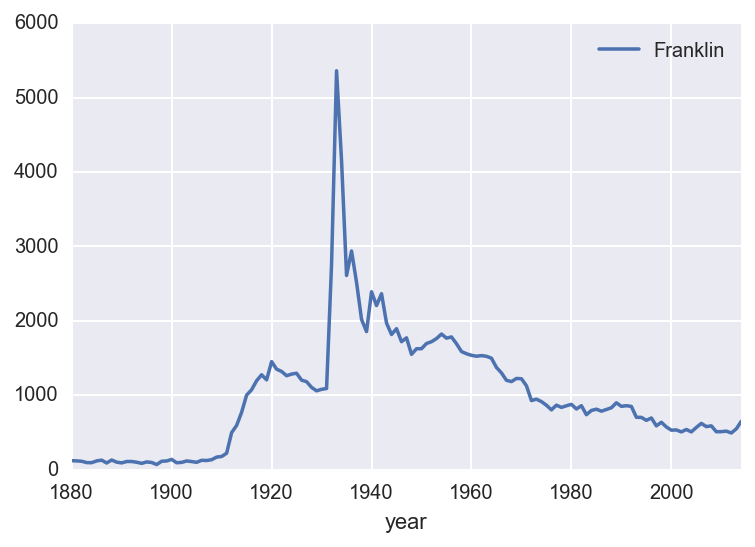

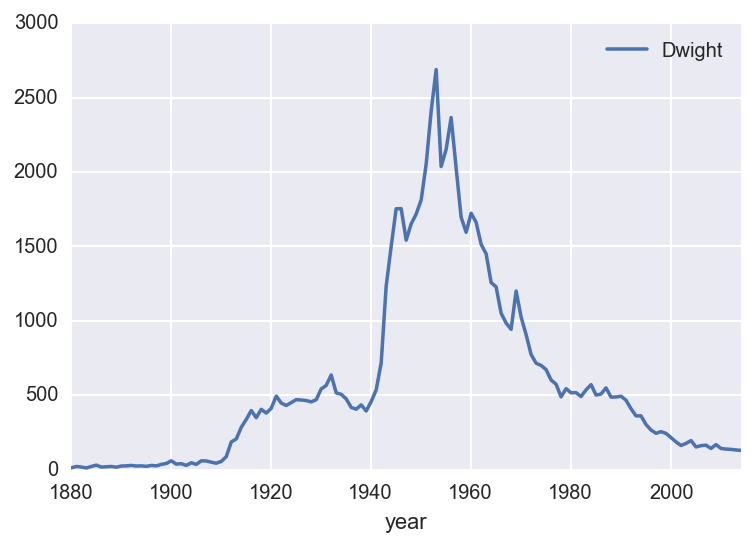

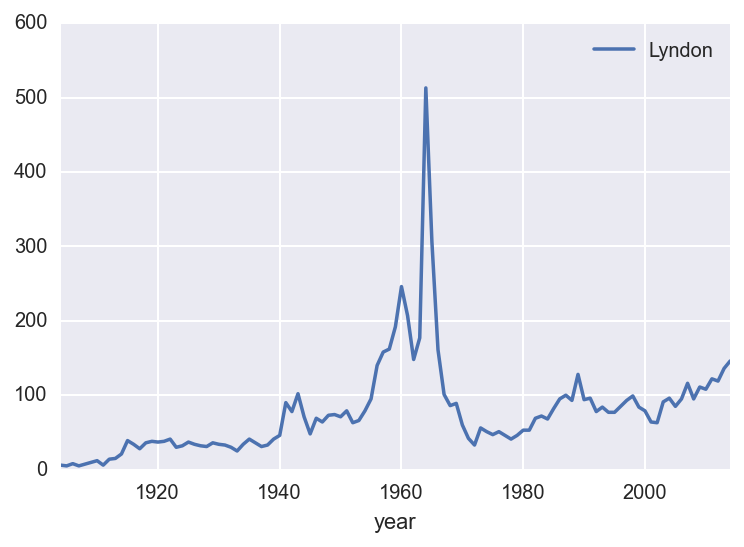

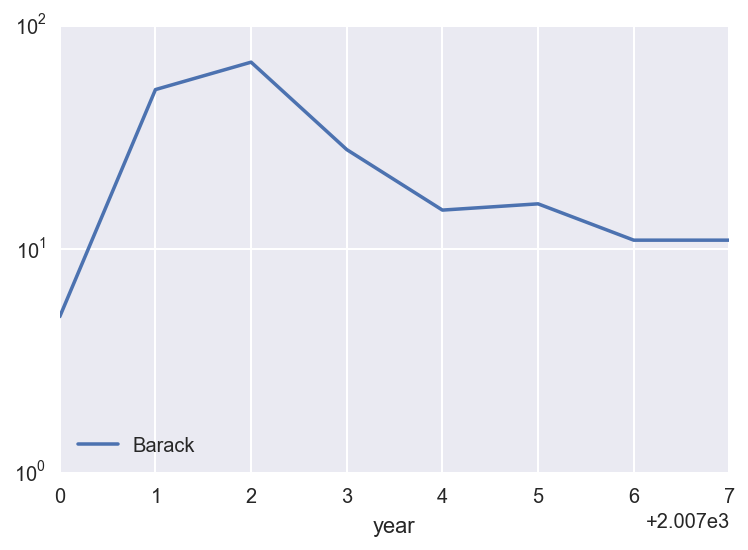

In [5]:
# There's a spike in the popularity of presidential first names
# when they are elected

plt.figure()
plot_name_frac('M', 'Woodrow')
plot_name_frac('M', 'Warren')
plot_name_frac('M', 'Calvin')
plot_name_frac('M', 'Herbert')
plot_name_frac('M', 'Franklin')
plot_name_frac('M', 'Dwight')
plot_name_frac('M', 'Lyndon')
plot_name_frac('M', 'Barack')
plt.yscale('log')
plt.legend(loc='lower left')

*Copyright &copy; 2015 The Data Incubator.  All rights reserved.*